In [128]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.style
import matplotlib as mpl

mpl.style.use('classic')

import baraffe_tables
from baraffe_tables.table_search import baraffe_table_search

from astropy.table import Table
from astropy import units as u
from astropy.constants import G

from scipy.optimize import fsolve

import mesa_helper as mh
import os
import shutil

%matplotlib inline

In [257]:
pp_extras_species = ['h1', 'h2', 'he3', 'he4', 'li7', 'be7', 'b8', 'c12', 'n14', 'o16', 'ne20', 'mg24']

# mass fractions for h1, h2, he3, he4, li7, c12, n14, o16, ne20 come from Lodders 2021
# mass fractions for be7, b8 come from MESA gs98 chem lib (Grevesse & Sauval 1998) (but note, these are so so trace)
# mass fraction for mg24 is 1 - sum of all the others
pp_extras_protosolar_mass_fractions = np.array((7.057e-1, 2.781e-5, 3.461e-5, 2.769e-1, 1.025e-8, 3.592e-89, 1.e-99, 3.011e-3, 8.482e-4, 7.377e-3, 2.261e-3, 5.398e-4))
pp_extras_protosolar_mass_fractions[-1] = 1.0 - np.sum(pp_extras_protosolar_mass_fractions[:-1])

pp_extras_XY = pp_extras_protosolar_mass_fractions[0]/pp_extras_protosolar_mass_fractions[3]
print(pp_extras_XY)
pp_extras_X = np.sum(pp_extras_protosolar_mass_fractions[0:2])
print(pp_extras_X)
pp_extras_Y = np.sum(pp_extras_protosolar_mass_fractions[2:4])
print(pp_extras_Y)
pp_extras_Z = np.sum(pp_extras_protosolar_mass_fractions[4:])
print(pp_extras_Z)

2.548573492235464
0.70572781
0.27693460999999997
0.01733758000000024


In [123]:
tp = Table.read("../reproducePaxton+2011fig18_24.08.1/make_brown_dwarf/LOGS_pp_extras/profile3.data", format="ascii", header_start=4, data_start=5)
print(tp)
print(tp.colnames)

zone          mass          ... brunt_N2_sub_omega2 sl2_sub_omega2
---- ---------------------- ... ------------------- --------------
   1   0.010004446413508129 ...                 1.0            0.0
   2   0.010004446413498125 ...                 1.0            0.0
   3    0.01000444641348562 ...                 1.0            0.0
   4   0.010004446413473114 ...                 1.0            0.0
   5   0.010004446413448102 ...                 1.0            0.0
   6    0.01000444641339808 ...                 1.0            0.0
   7   0.010004446413273025 ...                 1.0            0.0
   8    0.01000444641314797 ...                 1.0            0.0
   9   0.010004446412897858 ...                 1.0            0.0
  10   0.010004446412397635 ...                 1.0            0.0
 ...                    ... ...                 ...            ...
 547    5.8545164584831e-07 ...                 0.0            1.0
 548  3.950056478270642e-07 ...                 0.0           

In [136]:
print(tp['dm'])

          dm          
----------------------
1.9892939999489274e+19
2.4866174999361597e+19
2.4866174999361593e+19
 4.973234999872318e+19
 9.946469999744637e+19
 2.486617499936159e+20
 2.486617499936159e+20
 4.973234999872318e+20
 9.946469999744635e+20
1.6251746421914185e+21
                   ...
 3.786847023003866e+26
 3.501431690798018e+26
2.3713458246697187e+26
1.0794967402094649e+26
 4.914156852271253e+25
2.2370589348720503e+25
1.0183715791312003e+25
4.6359140053819124e+24
1.9281038453137143e+24
 1.945812052902957e+24
Length = 556 rows


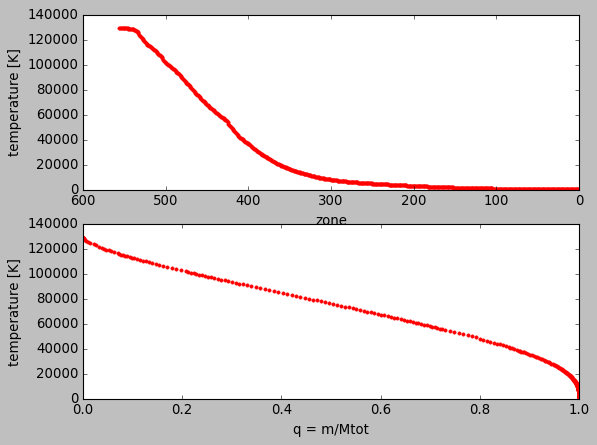

In [67]:
fig, axes = plt.subplots(2,1,figsize=(8,6))
#axes[0].plot(tp['zone'],tp['z_mass_fraction_metals'], 'k.')
axes[0].plot(tp['zone'],tp['temperature'], 'r.')
axes[0].set_xlabel('zone')
axes[0].set_ylabel('temperature [K]')
axes[0].invert_xaxis()
#axes[0].set_ylim(0,1)

#axes[1].plot(tp['q'],tp['z_mass_fraction_metals'], 'k.')
axes[1].plot(tp['q'],tp['temperature'], 'r.')
axes[1].set_xlabel('q = m/Mtot')
axes[1].set_ylabel('temperature [K]')
plt.show()

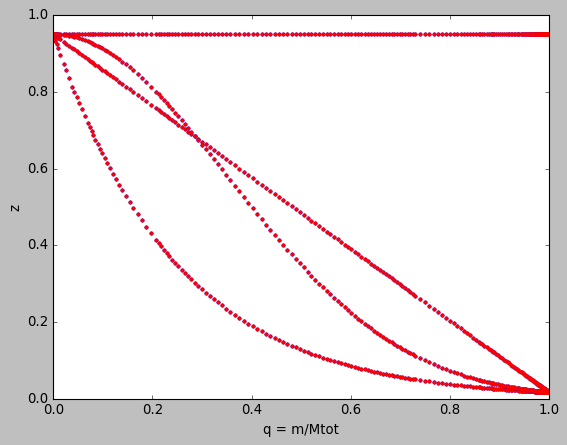

In [120]:
# q starts at 1 and goes to 0 
#xq starts at 0 and goes to 1

#z(xq) should start low and go high

uniform_z = zmax*np.ones_like(tp['q'])
linear_z = zmax-(zmax-pp_extras_Z)*np.array(tp['q'])
exp_z = zmax * (zmax/pp_extras_Z)**(-np.array(tp['q']))
gaussian_z = zmax * (zmax/pp_extras_Z)**(-np.array(tp['q'])**2)

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(tp['q'], uniform_z, 'b.')
ax.plot(1-tp['xq'], uniform_z, 'r.')

ax.plot(tp['q'], linear_z, 'b.')
ax.plot(1-tp['xq'], linear_z, 'r.')

ax.plot(tp['q'], exp_z, 'b.')
ax.plot(1-tp['xq'], exp_z, 'r.')

ax.plot(tp['q'], gaussian_z, 'b.')
ax.plot(1-tp['xq'], gaussian_z, 'r.')

ax.set_xlabel("q = m/Mtot")
ax.set_ylabel("z")
plt.show()

57.7504595167869 earthMass
9.296689733349273e-09
0.08261141244539986
60.0 earthMass


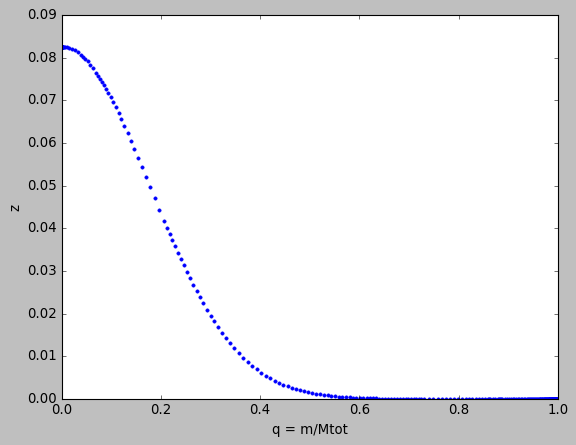

In [261]:
def total_metal_mass(zone_z, zone_dm):
    zone_zmass = (zone_z*zone_dm)
    return np.sum(zone_zmass)

z = total_metal_mass(tp['z_mass_fraction_metals'], tp['dm']*u.g)
print(z.to(u.earthMass))

def generate_uniform_profile(q, dm, protosolar_Z=0.01733758, desired_total_metals=60*u.earthMass, species=pp_extras_species, protosolar_mass_fractions=pp_extras_protosolar_mass_fractions):
    m_planet = np.sum(np.array(dm)) * u.g
    zs = (desired_total_metals.to(u.g)/m_planet) * np.ones_like(np.array(q))
    return zs         


def linear_metal_mass(Z_max, *other_req_args):
    #other required args are:
    # q array
    # dm array
    # desired total metals in units of earth masses
    # protosolar z
    q, dm, desired_total_metals, protosolar_z = other_req_args
    zs = Z_max - (Z_max - protosolar_Z)*np.array(q)
    metal_mass = np.sum(zs * np.array(dm)) * u.g
    return metal_mass.to(u.earthMass).value - desired_total_metals.value

def generate_linear_profile(q, dm, desired_total_metals=60*u.earthMass, protosolar_Z=0.01733758, species=pp_extras_species, protosolar_mass_fractions=pp_extras_protosolar_mass_fractions):
    # use fsolve to get the appropriate Z_max for the desired total metal mass
    other_req_args = (np.array(q), np.array(dm), desired_total_metals, protosolar_Z)
    Z_max = fsolve(linear_metal_mass, 0.1, args=other_req_args)[0]

    zs = Z_max - (Z_max - protosolar_Z)*np.array(q)
    return zs


def exponential_metal_mass(Z_max, *other_req_args):
    #other required args are:
    # q array
    # dm array
    # desired total metals in units of earth masses
    # protosolar z
    q, dm, desired_total_metals, protosolar_z = other_req_args
    zs = Z_max * (Z_max/protosolar_Z)**(-np.array(q))
    metal_mass = np.sum(zs * np.array(dm)) * u.g
    return metal_mass.to(u.earthMass).value - desired_total_metals.value

def generate_exponential_profile(q, dm, desired_total_metals=60*u.earthMass, protosolar_Z=0.01733758, species=pp_extras_species, protosolar_mass_fractions=pp_extras_protosolar_mass_fractions):
    # use fsolve to get the appropriate Z_max for the desired total metal mass
    other_req_args = (np.array(q), np.array(dm), desired_total_metals, protosolar_Z)
    Z_max = fsolve(exponential_metal_mass, 0.1, args=other_req_args)[0]

    zs = Z_max * (Z_max/protosolar_Z)**(-np.array(q))
    return zs

def gaussian_leveloff_metal_mass(Z_max, *other_req_args):
    #other required args are:
    # q array
    # dm array
    # desired total metals in units of earth masses
    # protosolar z
    q, dm, desired_total_metals, protosolar_z = other_req_args
    zs = Z_max * (Z_max/protosolar_Z)**(-(np.array(q))**2)
    metal_mass = np.sum(zs * np.array(dm)) * u.g
    return metal_mass.to(u.earthMass).value - desired_total_metals.value

def generate_gaussian_leveloff_profile(q, dm, desired_total_metals=60*u.earthMass, protosolar_Z=0.01733758, species=pp_extras_species, protosolar_mass_fractions=pp_extras_protosolar_mass_fractions):
    # use fsolve to get the appropriate Z_max for the desired total metal mass
    other_req_args = (np.array(q), np.array(dm), desired_total_metals, protosolar_Z)
    Z_max = fsolve(gaussian_leveloff_metal_mass, 0.1, args=other_req_args)[0]

    zs = Z_max * (Z_max/protosolar_Z)**(-(np.array(q))**2)
    return zs

def gaussian_metal_mass(Z_max, *other_req_args):
    #other required args are:
    # q array
    # dm array
    # desired total metals in units of earth masses
    # protosolar z
    q, dm, desired_total_metals, stdev = other_req_args
    zs =  Z_max * np.exp(-(np.array(q)/stdev)**2)
    metal_mass = np.sum(zs * np.array(dm)) * u.g
    return metal_mass.to(u.earthMass).value - desired_total_metals.value

def generate_gaussian_profile(q, dm, stdev=1, desired_total_metals=60*u.earthMass, protosolar_Z=0.01733758, species=pp_extras_species, protosolar_mass_fractions=pp_extras_protosolar_mass_fractions):
    # use fsolve to get the appropriate Z_max for the desired total metal mass
    other_req_args = (np.array(q), np.array(dm), desired_total_metals, stdev)
    Z_max = fsolve(gaussian_metal_mass, 0.1, args=other_req_args)[0]

    zs = Z_max * np.exp(-(np.array(q)/stdev)**2)
    return zs
    

test = generate_gaussian_profile(tp['q'],tp['dm'], stdev=0.25, desired_total_metals=60*u.earthMass)
print(test[0])
print(test[-1])
test_total_metals = np.sum(test * tp['dm']*u.g)
print(test_total_metals.to(u.earthMass))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(tp['q'], test, 'b.')
ax.set_xlabel("q = m/Mtot")
ax.set_ylabel("z")
plt.show()

In [249]:
def generate_profile(q, dm, form='uniform', protosolar_Z=0.01733758, stdev=None, desired_total_metals=60*u.earthMass, species=pp_extras_species, protosolar_mass_fractions=pp_extras_protosolar_mass_fractions):
    if form == 'uniform':
        zs = generate_uniform_profile(q, dm, protosolar_Z=protosolar_Z, desired_total_metals=desired_total_metals, species=species, protosolar_mass_fractions=protosolar_mass_fractions)
    elif form == 'linear':
        zs = generate_linear_profile(q, dm, protosolar_Z=protosolar_Z, desired_total_metals=desired_total_metals, species=species, protosolar_mass_fractions=protosolar_mass_fractions)
    elif form == 'exponential':
        zs = generate_exponential_profile(q, dm, protosolar_Z=protosolar_Z, desired_total_metals=desired_total_metals, species=species, protosolar_mass_fractions=protosolar_mass_fractions)
    elif form == 'gaussian':
        zs = generate_gaussian_profile(q, dm, stdev=stdev, protosolar_Z=protosolar_Z, desired_total_metals=desired_total_metals, species=species, protosolar_mass_fractions=protosolar_mass_fractions)
    elif form == 'gaussian_leveloff':
        zs = generate_gaussian_leveloff_profile(q, dm, protosolar_Z=protosolar_Z, desired_total_metals=desired_total_metals, species=species, protosolar_mass_fractions=protosolar_mass_fractions)
    
    return zs

In [250]:
protosolar_X = np.sum(pp_extras_protosolar_mass_fractions[0:2])
protosolar_Y = np.sum(pp_extras_protosolar_mass_fractions[2:4])
protosolar_Z = np.sum(pp_extras_protosolar_mass_fractions[4:])

    
protosolar_h1 = pp_extras_protosolar_mass_fractions[0]/protosolar_X
protosolar_h2 = pp_extras_protosolar_mass_fractions[1]/protosolar_X
protosolar_he3 = pp_extras_protosolar_mass_fractions[2]/protosolar_Y
protosolar_he4 = pp_extras_protosolar_mass_fractions[3]/protosolar_Y
protosolar_li7 = pp_extras_protosolar_mass_fractions[4]/protosolar_Z
protosolar_be7 = pp_extras_protosolar_mass_fractions[5]/protosolar_Z
protosolar_b8 = pp_extras_protosolar_mass_fractions[6]/protosolar_Z
protosolar_c12 = pp_extras_protosolar_mass_fractions[7]/protosolar_Z
protosolar_n14 = pp_extras_protosolar_mass_fractions[8]/protosolar_Z
protosolar_o16 = pp_extras_protosolar_mass_fractions[9]/protosolar_Z
protosolar_ne20 = pp_extras_protosolar_mass_fractions[10]/protosolar_Z
protosolar_mg24 = pp_extras_protosolar_mass_fractions[11]/protosolar_Z

def generate_and_save_profile(profile_table, form='uniform', savefilename="./composition.dat", stdev=None, fortran_format=False, protosolar_Z=0.01733758, desired_total_metals=60*u.earthMass, species=pp_extras_species, protosolar_mass_fractions=pp_extras_protosolar_mass_fractions):
    '''
    arguments:
    profile_table = a MESA profile in astropy table format
    '''
    zs = generate_profile(q=profile_table['q'], dm=profile_table['dm'], form=form, stdev=stdev, protosolar_Z=protosolar_Z, desired_total_metals=desired_total_metals, species=species, protosolar_mass_fractions=protosolar_mass_fractions)

    nzones = len(profile_table['q'])
    nspecies = len(pp_extras_species)

    header = '        {0}           {1}'.format(nzones, nspecies)

    composition = np.zeros((nzones, nspecies+1))
    composition[:,0] = np.array(profile_table['xq'])

    ys = (1 - zs)/((protosolar_X/protosolar_Y) + 1)
    xs = 1.0 - ys - zs

    composition[:,1] = xs * protosolar_h1
    composition[:,2] = xs * protosolar_h2
    composition[:,3] = ys * protosolar_he3
    composition[:,4] = ys * protosolar_he4
    composition[:,5] = zs * protosolar_li7
    composition[:,6] = zs * protosolar_be7
    composition[:,7] = zs * protosolar_b8
    composition[:,8] = zs * protosolar_c12
    composition[:,9] = zs * protosolar_n14
    composition[:,10] = zs * protosolar_o16
    composition[:,11] = zs * protosolar_ne20
    composition[:,12] = zs * protosolar_mg24

    np.savetxt(savefilename, composition, delimiter='  ',newline='\n  ', header=header, comments='')

    if fortran_format is True:
        with open(savefilename, 'r') as f:
            filedata = f.read()
        filedata = filedata.replace('e','D')
        with open(savefilename, 'w') as f:
            f.write(filedata)
               
    return

In [ ]:
generate_and_save_profile(tp, form='gaussian', savefilename="./test_gaussian_composition.dat", stdev=0.5, fortran_format=False, protosolar_Z=0.01733758, desired_total_metals=60*u.earthMass, species=pp_extras_species, protosolar_mass_fractions=pp_extras_protosolar_mass_fractions)

(556, 13)


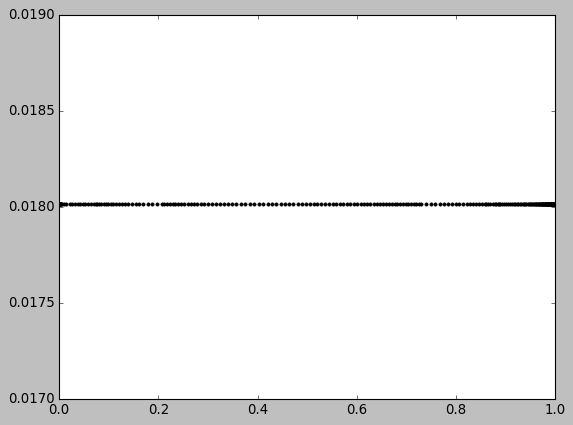

In [262]:
loadtest = np.genfromtxt("./test_script_uniform_profile.txt", skip_header=1)
print(np.shape(loadtest))

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(1.-loadtest[:,0], np.sum(loadtest[:,5:],axis=1), 'k.')
plt.show()